In [36]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.cluster import KMeans 

In [37]:
# Reading the data from the csv file
data = pd.read_csv('GPSapps/googleplaystore.csv')

In [38]:
# Clean data from negative, nan, zero values
data = data.replace([float('inf'), float('-inf'),str('NaN')], pd.NA).dropna()
data.head()
print(data.dtypes)

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


App                object
Category           object
Rating            float64
Reviews             int64
Size               object
Installs            int64
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


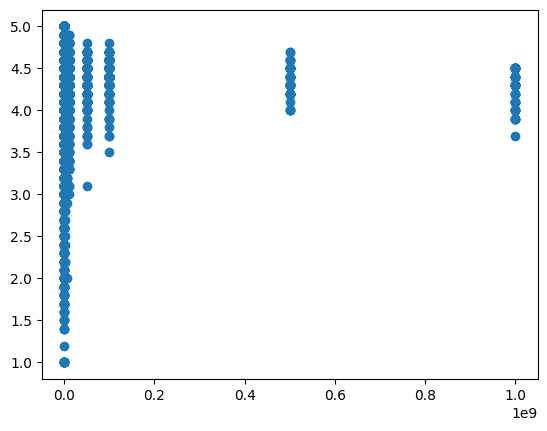

In [39]:
# Transforming non-numerical data to numerical data
data.dtypes

# reviews to int
# data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce')
# data['Size'] = data['Size'][0:-1]

# Convert 'Reviews' to numeric
data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce')

# Remove invalid entries in 'Installs' and convert to integers
data['Installs'] = data['Installs'].astype(str)
data['Installs'] = data['Installs'].str.replace('[+,]', '', regex=True).astype(int)
data['Installs'] = pd.to_numeric(data['Installs'], errors='coerce')

# Convert 'Price' to numeric
data['Price'] = data['Price'].astype(str)
data['Price'] = data['Price'].str.replace('$', '', regex=True)
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

# Convert 'Size' to numberic
data['Size'] = data['Size'].astype(str).fillna('')

# Function to normalize 'Size' to MB
# def size_to_mb(size):
#     if 'M' in size:
#         return float(size.replace('M', ''))
#     elif 'k' in size:
#         return float(size.replace('k', '')) / 1024
#     elif size == '' or size == 'Varies with device':
#         return None 
#     else:
#         return None  

# data['Size'] = data['Size'].apply(size_to_mb)

print(data.dtypes)
plt.scatter(data['Installs'],data['Rating'])


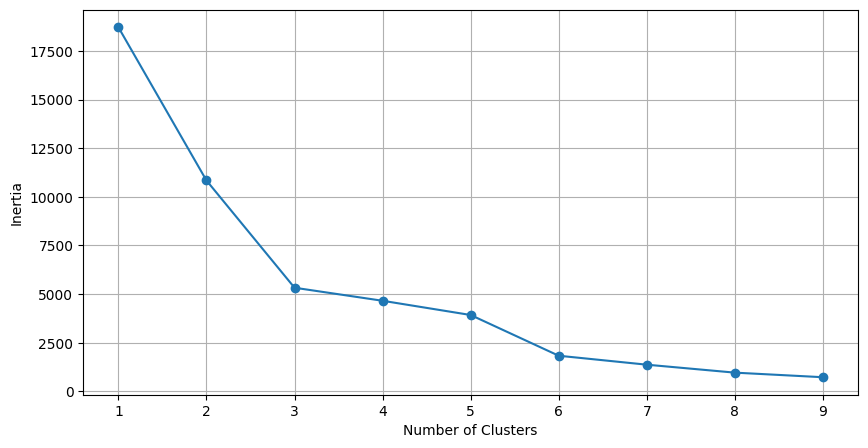

In [40]:
scaler = StandardScaler()

data[['Installs_T', 'Reviews_T', 'Rating_T']] = scaler.fit_transform(data[['Installs', 'Reviews', 'Rating']])

def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10,5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

optimise_k_means(data[['Installs_T', 'Rating_T']], 10)

In [41]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data[['Installs_T', 'Rating_T']])
data['kmeans_3'] = kmeans.labels_
data.head()


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_T,Reviews_T,Rating_T,kmeans_3
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,-0.196126,-0.163511,-0.178244,2
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,-0.190757,-0.163254,-0.566416,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,-0.141448,-0.135735,0.986272,2
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,0.351641,-0.094991,0.598100,2
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,-0.195140,-0.163254,0.209928,2


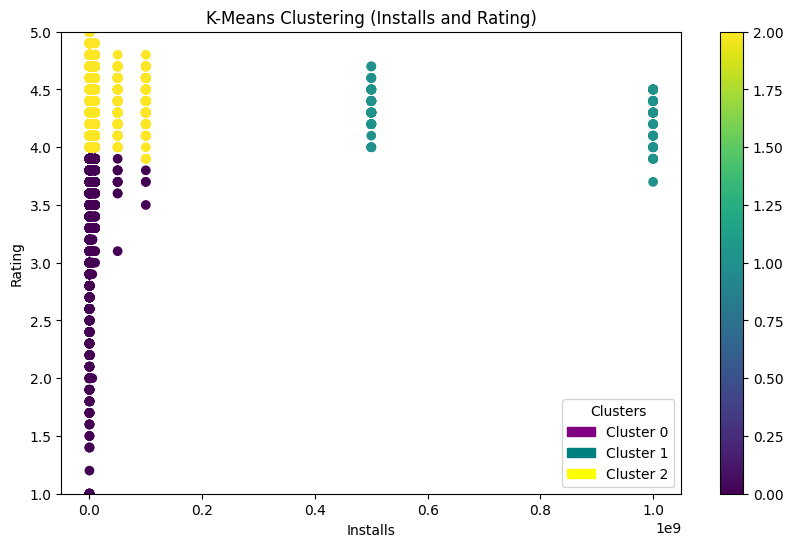

In [42]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x=data['Installs'], y=data['Rating'], c=data['kmeans_3'])
plt.xlabel('Installs')
plt.ylabel('Rating')
plt.ylim(1.0, 5.0)
plt.title('K-Means Clustering (Installs and Rating)') 
plt.colorbar(scatter)

legend_handles = [ 
    mpatches.Patch(color='purple', label='Cluster 0'), 
    mpatches.Patch(color='teal', label='Cluster 1'), 
    mpatches.Patch(color='yellow', label='Cluster 2')
]

# Add the legend
plt.legend(handles=legend_handles, title='Clusters', loc='lower right')

# Show the plot
plt.show()

# Set display options to show all rows and columns 
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

# Sort the DataFrame by the 'Cluster' column 
sorted_data = data.sort_values(by='kmeans_3') 


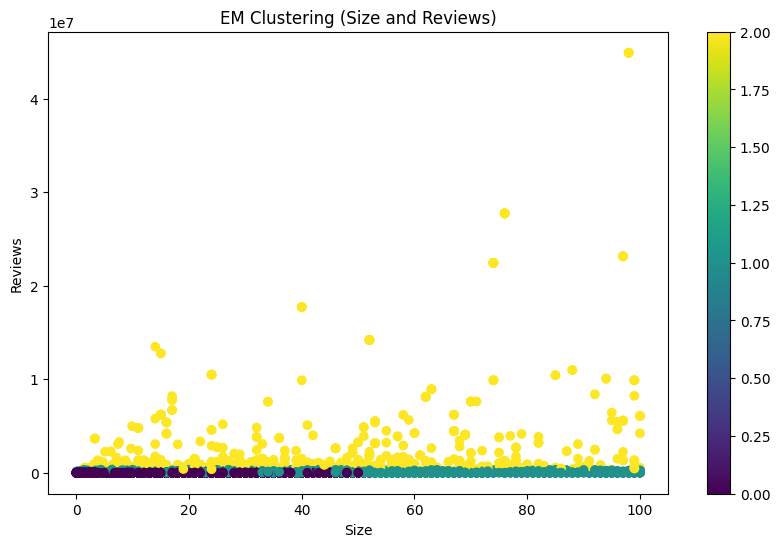

In [43]:
# Convert 'Size' to numeric by removing non-numeric characters (like 'M', 'k', etc.)
def size_to_numeric(size):
    if 'M' in size:
        return float(size.replace('M', ''))  # Convert MB values to numeric
    elif 'k' in size:
        return float(size.replace('k', '')) / 1024  # Convert KB to MB
    elif size == '' or size == 'Varies with device':
        return None  # Handle missing or device-specific values
    else:
        return None  # For any unexpected values

# Apply this function to the 'Size' column
data['Size'] = data['Size'].apply(size_to_numeric)

# Convert 'Reviews' to numeric, coerce errors to NaN
data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce')

# Drop rows with missing 'Size' or 'Reviews' values
data = data.dropna(subset=['Size', 'Reviews'])

# Now apply the scaling to 'Size' and 'Reviews'
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[['Size_T', 'Reviews_T']] = scaler.fit_transform(data[['Size', 'Reviews']])

# Fit a Gaussian Mixture Model (GMM) with 3 clusters
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(data[['Size_T', 'Reviews_T']])

# Predict the clusters
data['gmm_size_reviews_clusters'] = gmm.predict(data[['Size_T', 'Reviews_T']])

# Visualize the clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x=data['Size'], y=data['Reviews'], c=data['gmm_size_reviews_clusters'])
plt.xlabel('Size')
plt.ylabel('Reviews')
plt.title('EM Clustering (Size and Reviews)')
plt.colorbar(scatter)
plt.show()
